##**Kmeans Algorithm And Example**

In [0]:
# Install the GraphFrames library
%pip install graphframes

from pyspark.sql import SparkSession
from graphframes import GraphFrame
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import pandas as pd
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

def constract_query_from_user_row_llm(
    about_column, city_column, education_column, experience_column, courses_column):
    about = about_column if about_column is not None else ''
    city = city_column if city_column is not None else ''
    education_list = []
    for education in education_column:
        cur_ed_dict = dict()
        cur_ed_dict['degree'] = education['degree'] if education['degree'] is not None else ''
        cur_ed_dict['field'] = education['field'] if education['field'] is not None else ''
        cur_ed_dict['university'] = education['title'] if education['title'] is not None else ''
        education_list.append(cur_ed_dict)

    experience_list = []
    for experience in experience_column:
        cur_exp_dict = dict()
        cur_exp_dict['company'] = experience['company'] if experience['company'] is not None else ''
        cur_exp_dict['title'] = experience['title'] if experience['title'] is not None else ''
        cur_exp_dict['subtitle'] = experience['subtitle'] if experience['subtitle'] is not None else ''
        cur_exp_dict['location'] = experience['location'] if experience['location'] is not None else ''
        cur_exp_dict['description'] = experience['description'] if experience['description'] is not None else ''

        duration = experience['duration_short']
        if duration is not None:
            stripes = duration.split(' ')
            total_months = 0
            for i in range(int(len(stripes) / 2)):
                try:
                    num = int(stripes[2 * i])
                    if stripes[2 * i + 1] == 'year' or stripes[2 * i + 1] == 'years':
                        num *= 12
                    total_months += num
                except ValueError:
                    continue

            cur_exp_dict['total_years'] = total_months / 12.0
            cur_exp_dict['lexical_time'] = duration
        else:
            cur_exp_dict['total_years'] = None
            cur_exp_dict['lexical_time'] = 'unknown duration'

        cur_exp_dict['positions'] = []
        if experience['positions'] is not None:
            for position in experience['positions']:
                cur_pos_dict = dict()
                cur_pos_dict['title'] = position['title'] if position['title'] is not None else ''
                cur_exp_dict['positions'].append(cur_pos_dict)

        experience_list.append(cur_exp_dict)

    final_data = {
        'about': about,
        'city': city,
        'education': education_list,
        'experience': experience_list,
    }

    education_query = '\n'
    for education in education_list:
        education_query += (
            education['degree']
            + ' in '
            + education['field']
            + ' at '
            + education['university']
            + '. \n'
        )

    if len(education_list) == 0:
        education_query += 'not mentioned'

    course_list = [c['title'] if c['title'] is not None else '' for c in courses_column]
    courses_query = '\n'.join(course_list)
    query = f'''
    my about is: {about}.
    I prefer to work at: {city}.
    My education is: {education_query}
    courses I took: \n {courses_query}
    '''

    experience_query = "\n I worked at:"
    for experience in experience_list:
        exp_loc = experience['location'] if experience['location'] is not None else 'unknown location'
        exp_lec_time = experience['lexical_time'] if experience['lexical_time'] is not None else 'unknown duration'

        if experience['company'] is not None and experience['title'] is not None:
            experience_query += '\n' + experience['company'] + ' as ' + experience['title'] + ' at ' + exp_loc + ', for ' + exp_lec_time + '. '
        elif experience['subtitle'] is not None and experience['title'] is not None:
            experience_query += '\n' + experience['subtitle'] + ' as ' + experience['title'] + ' at ' + exp_loc + ', for ' + exp_lec_time + '. '
        elif experience['title'] is None and experience['positions'] != []:
            if experience['company'] is not None:
                experience_query += '\n' + experience['company'] + ' as '
            elif experience['subtitle'] is not None:
                experience_query += '\n' + experience['subtitle'] + ' as '

            for position in experience['positions']:
                experience_query += position['title'] + ', '

            experience_query = experience_query[:-2] + ', for ' + exp_lec_time + '. '

        if experience['description'] is not None:
            experience_query += '\nthe job description:\n'
            experience_query += experience['description']
        experience_query += '\n'

    query += experience_query

    return query

spark = SparkSession.builder.getOrCreate()

from sparknlp.annotator import BertSentenceEmbeddings
from sparknlp.base import DocumentAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, to_json, from_json
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType, LongType
document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# --- Step 2: BERT Sentence Embeddings for jobs ---
bert_sentence_embeddings = BertSentenceEmbeddings.pretrained("sent_small_bert_L2_128", "en") \
    .setInputCols(["document"]) \
    .setOutputCol("bert_sentence_embeddings")

# --- Step 3: Pipeline for jobs DataFrame ---
pipeline = Pipeline(stages=[
    document_assembler,
    bert_sentence_embeddings
])

from pyspark.sql.functions import col, lower
from pyspark.sql.types import StringType

companies = spark.read.parquet('/dbfs/linkedin_train_data')
sphere = companies.select('sphere').distinct().withColumn('sphere', lower(col('sphere').cast(StringType()))).distinct()
sphere_count = sphere.filter(companies.sphere.isNotNull()).count()

  Obtaining dependency information for graphframes from https://files.pythonhosted.org/packages/0b/27/c7c7e1ced2fe9a905f865dd91faaec2ac8a8e313f511678c8ec92a41a153/graphframes-0.6-py2.py3-none-any.whl.metadata
  Obtaining dependency information for nose from https://files.pythonhosted.org/packages/15/d8/dd071918c040f50fa1cf80da16423af51ff8ce4a0f2399b7bf8de45ac3d9/nose-1.3.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/154.7 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.6/154.7 kB 5.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [0]:
from pyspark.ml.evaluation import ClusteringEvaluator

constract_query_from_user_row_llm_udf = udf(constract_query_from_user_row_llm, StringType())
profiles = spark.read.parquet('/dbfs/linkedin_people_train_data')
profiles_text = profiles.withColumn(
    'text',
    constract_query_from_user_row_llm_udf(
        col('about'), col('city'), col('education'), col('experience'), col('сourses')
    )
)
model_profiles = pipeline.fit(profiles_text)
result_profiles = model_profiles.transform(profiles_text)

profiles_embeddings = result_profiles.withColumn(
        "embeddings_profiles",
        col("bert_sentence_embeddings").getItem(0).getField("embeddings")
    ).drop("document", "bert_sentence_embeddings").dropDuplicates()

profiles_embeddings.cache()
sample_profiles = profiles_embeddings.filter(col('about').isNotNull()).sample(False, 0.2)
kmeans = KMeans(featuresCol="embeddings_profiles", predictionCol="cluster", k=148)
kmeans_model = kmeans.fit(sample_profiles)
clustered_profiles = kmeans_model.transform(profiles_embeddings)
clustered_profiles.cache()

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

DataFrame[about: string, avatar: string, certifications: array<struct<meta:string,subtitle:string,title:string>>, city: string, country_code: string, current_company: struct<company_id:string,industry:string,link:string,name:string,title:string>, current_company:company_id: string, current_company:name: string, education: array<struct<degree:string,end_year:string,field:string,meta:string,start_year:string,title:string,url:string>>, educations_details: string, experience: array<struct<company:string,company_id:string,description:string,duration:string,duration_short:string,end_date:string,location:string,positions:array<struct<description:string,duration:string,duration_short:string,end_date:string,meta:string,start_date:string,subtitle:string,title:string>>,start_date:string,subtitle:string,subtitleURL:string,title:string,url:string>>, followers: bigint, following: bigint, groups: array<string>, id: string, languages: array<struct<subtitle:string,title:string>>, name: string, people_a

In [0]:
# Evaluate clustering by computing Within Set Sum of Squared Errors (WSSSE)
wssse = kmeans_model.summary.trainingCost

# Add the prediction column to clustered_profiles
clustered_profiles = clustered_profiles.withColumn("prediction", col("cluster"))

evaluator = ClusteringEvaluator(featuresCol="embeddings_profiles", predictionCol="prediction")
silhouette = evaluator.evaluate(clustered_profiles)

# Display evaluation metrics
display(spark.createDataFrame([(wssse, silhouette)], ["WSSSE", "Silhouette"]))

In [0]:
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F
import numpy as np

# Compute the global centroid (mean of all embeddings)
global_centroid = profiles_embeddings.select(F.expr('aggregate(embeddings_profiles, 0D, (acc, x) -> acc + x) / size(embeddings_profiles)')).collect()[0][0]

# Define a UDF to compute squared Euclidean distance
def squared_distance(embedding):
    return float(np.sum((np.array(embedding) - np.array(global_centroid))**2))

squared_distance_udf = udf(squared_distance, FloatType())

# Compute WSSSE for a single cluster
single_cluster_wssse = profiles_embeddings.withColumn(
    "squared_distance", squared_distance_udf(col("embeddings_profiles"))
).agg(F.sum("squared_distance")).collect()[0][0]

print(f"WSSSE for a single cluster (baseline): {single_cluster_wssse}")


In [0]:
from pyspark.sql.functions import explode, split, lower, sum, count
def get_cluster_values(profile_id):
    # creating cluster of the test subject
    person_profile = clustered_profiles.filter(col('id') == profile_id).first()
    claster_id = person_profile['cluster']
    print(claster_id)
    cluster = clustered_profiles.filter(col('cluster') == claster_id)
    claster_ordered_by_followers = cluster.orderBy(col("following").desc())

    most_followed = claster_ordered_by_followers.filter(col('about').isNotNull()).limit(200)
    courses_list = most_followed.select('сourses').withColumn(
        "сourses", explode("сourses")
    ).select("сourses.title").limit(50).collect()

    # preparing data for retrival
    claster_find_leaders = claster_ordered_by_followers.withColumn("expirince_size", size(col('experience')))
    claster_find_leaders = claster_find_leaders.withColumn("exploded_experience", explode("experience"))
    claster_find_leaders = claster_find_leaders.withColumn("position_len", when(size(col('exploded_experience').getField('positions')) == -1, 0).otherwise(size(col('exploded_experience').getField('positions'))))
    claster_find_leaders = claster_find_leaders.groupBy("id", *claster_ordered_by_followers.columns, "expirince_size").agg(
        sum("position_len").alias("total_position_len"),
        count("*").alias("row_count")
    )
    claster_find_leaders = claster_find_leaders.withColumn("experience_final", col('total_position_len') + col('expirince_size') )

    expirence_size = claster_find_leaders.filter(col('id') == profile_id).first()['experience_final']
    followed_profile_similar = claster_find_leaders.filter(col('about').isNotNull()).filter(col('experience_final') == expirence_size).orderBy(col("followers").desc()).limit(10).collect()

    followed_profile_plus1 = (
    claster_find_leaders
    .filter(col('experience_final') == expirence_size + 1)
    .filter(col('about').isNotNull())
    .select("experience", "followers")
    .withColumn("exploded_experience", split(col("experience").getItem(0).getField("title"), '[,-]').getItem(0))
    .groupBy("exploded_experience")
    .agg(sum("followers").alias("total_followers"))
    .orderBy(col("total_followers").desc())
    .filter(col("exploded_experience").isNotNull() & col("exploded_experience").contains(' '))
    .select("exploded_experience")
    .limit(10)).collect()

    most_mentioned_companies = (
    claster_ordered_by_followers
    .limit(500)
    .withColumn("name", col("current_company.name"))
    .groupBy("name")
    .count()
    .orderBy(col("count").desc())
    .filter(col("name").isNotNull() & (lower(col("name")) != 'university') &  (lower(col("name")) != 'the') & (lower(col("name")) != 'of') & (lower(col("name")) != 'self-employed') & (lower(col("name")) != '-'))
    .limit(10)
    .select("name")
    ).collect()

    results = {'id': profile_id, 'courses': courses_list, 'leaders': followed_profile_similar, 'companies': most_mentioned_companies, 'leaders_plus1': followed_profile_plus1}
    return results
    

**Example of how the function is dismantled and presented for one account:**

In [0]:
from pyspark.sql.functions import explode, split, lower, sum, count

# Use the first test_id
test_id = 'gm19'

# creating cluster of the test subject
person_profile = clustered_profiles.filter(col('id') == test_id).first()
claster_id = person_profile['cluster']
print(claster_id)
cluster = clustered_profiles.filter(col('cluster') == claster_id)
claster_ordered_by_followers = cluster.orderBy(col("following").desc())

**the profile data**

In [0]:
print(person_profile['text'])


    my about is: .
    I prefer to work at: Kalamazoo, Michigan, United States.
    My education is: 
 in  at Dartmouth College. 
 in  at McCallie School. 

    courses I took: 
 
    
 I worked at:
Copley Equity Partners LLC as  at , for unknown duration. 
the job description:


 as Private Equity Summer Analyst at Sterling, VA, for 5 months. 
the job description:


 as Investment and Real Estate Intern at , for 3 months. 
the job description:


 as First Year Fellow at Washington D.C. Metro Area, for 3 months. 
the job description:
Selected as part of the Nelson A. Rockefeller Center for Public Policy’s First-Year Fellows program, which gives first-year students the opportunity to engage in public policy early in their Dartmouth careers. Each year, 20-25 students are selected for summer placement in a diverse range of policy internships in Washington, D.C. with Dartmouth alumni mentors. Responsibilities included research and writing, making oral presentations to staff, assisting wit

**list of couses that the user could take or learn**

In [0]:
# getting courses list
most_followed = claster_ordered_by_followers.filter(col('about').isNotNull()).limit(200)
courses_list = most_followed.select('сourses').withColumn(
    "сourses", explode("сourses")
).select("сourses.title").limit(50)
display(courses_list)

title
Data Analytics
Introduction to C#
Introduction to SQL Server
google analytics academy
Negotiation Mastery
USCG 100 Ton Master
Scaling Ventures Program
Strategic Thinking & Leadership


**Leader profiles that can be emulated**

In [0]:
# preparing data for retrival
claster_find_leaders = claster_ordered_by_followers.withColumn("expirince_size", size(col('experience')))
claster_find_leaders = claster_find_leaders.withColumn("exploded_experience", explode("experience"))
claster_find_leaders = claster_find_leaders.withColumn("position_len", when(size(col('exploded_experience').getField('positions')) == -1, 0).otherwise(size(col('exploded_experience').getField('positions'))))
claster_find_leaders = claster_find_leaders.groupBy("id", *claster_ordered_by_followers.columns, "expirince_size").agg(
    sum("position_len").alias("total_position_len"),
    count("*").alias("row_count")
)
claster_find_leaders = claster_find_leaders.withColumn("experience_final", col('total_position_len') + col('expirince_size') )

expirence_size = claster_find_leaders.filter(col('id') == test_id).first()['experience_final']
followed_profile_similar = claster_find_leaders.filter(col('about').isNotNull()).filter(col('experience_final') == expirence_size).orderBy(col("followers").desc()).limit(10)
display(followed_profile_similar)

id about avatar certifications city country_code current_company current_company:company_id current_company:name education educations_details experience followers following groups id languages name people_also_viewed position posts recommendations recommendations_count timestamp url volunteer_experience сourses text embeddings_profiles cluster prediction expirince_size total_position_len row_count experience_final d-j-thomas-322244b6 Contact me at dj@frequencyinterrupted.com https://static.licdn.com/aero-v1/sc/h/244xhbkr7g40x6bsu4gi6q4ry List() Shreveport, Louisiana, United States US List(hemingway-west, Hemingway West, https://www.linkedin.com/company/hemingway-west?trk=public_profile_topcard-current-company, Hemingway West, Podcast Host, Pitmaster, Director of Marketing, Managing Partner) hemingway-west Hemingway West List() null List(List(null, null, null, Jan 2016 - Present 7 years 9 months, 7 years 9 months, Present, null, null, Jan 2016, Hemingway West, https://www.linkedin.com/company/hemingway-west?trk=public_profile_experience-item_profile-section-card_subtitle-click, Director Of Sales & Marketing/Partner, null), List(null, null, null, Oct 2022 - Present 1 year, 1 year, Present, null, null, Oct 2022, Mammoth Equipment Rental, https://www.linkedin.com/company/mammoth-equipment-rental?trk=public_profile_experience-item_profile-section-card_subtitle-click, Managing Partner, null), List(null, null, null, Oct 2019 - Present 4 years, 4 years, Present, null, null, Oct 2019, Frequency Interrupted, null, Podcast Host, null), List(null, null, null, Nov 2021 - Present 1 year 11 months, 1 year 11 months, Present, null, null, Nov 2021, Pork & Fork BBQ, https://www.linkedin.com/company/pork-fork-bbq?trk=public_profile_experience-item_profile-section-card_subtitle-click, Pitmaster, null), List(null, null, null, Apr 2021 - Present 2 years 6 months, 2 years 6 months, Present, null, null, Apr 2021, American Kombat Alliance, null, Sports Commentator, null), List(null, null, null, Dec 2017 - Present 5 years 10 months, 5 years 10 months, Present, null, null, Dec 2017, La Rousse Events, https://www.linkedin.com/company/la-rousse-events?trk=public_profile_experience-item_profile-section-card_subtitle-click, Operating Partner, null), List(null, null, null, Apr 2015 Dec 2016 1 year 9 months, 1 year 9 months, Dec 2016, Shreveport, Louisiana, null, Apr 2015, Summit Casing Equipment, https://www.linkedin.com/company/summit-casing-equipment?trk=public_profile_experience-item_profile-section-card_subtitle-click, Field Sales Representative, null), List(null, null, null, Sep 2008 Jun 2015 6 years 10 months, 6 years 10 months, Jun 2015, Shreveport, Louisiana Area, null, Sep 2008, Weatherford International, https://www.linkedin.com/company/weatherford?trk=public_profile_experience-item_profile-section-card_subtitle-click, Field Sales and Service Representative, null)) 7000 7000 List() d-j-thomas-322244b6 List() D.J. Thomas List() Podcast Host, Pitmaster, Director of Marketing, Managing Partner List() List(Dickie Martin “DJ is very good with customers,has great communication skills and is product knowledgeable.”) 1 2023-09-04 https://www.linkedin.com/in/d-j-thomas-322244b6 List() List() 
 my about is: Contact me at dj@frequencyinterrupted.com.
 I prefer to work at: Shreveport, Louisiana, United States.
 My education is: 
not mentioned
 courses I took: 
 
 
 I worked at:
 as Director Of Sales & Marketing/Partner at , for 7 years 9 months. 
the job description:


 as Managing Partner at , for 1 year. 
the job description:


 as Podcast Host at , for 4 years. 
the job description:


 as Pitmaster at , for 1 year 11 months. 
the job description:


 as Sports Commentator at , for 2 years 6 months. 
the job description:


 as Operating Partner at , for 5 years 10 months. 
the job description:


 as Field Sales Representative at Shreveport, Louisiana, for 1 year 9 months. 
the job description:


 as Field Sales and Service Representative at Shreveport, Louisi

**Jobs to aspire to**

In [0]:
from pyspark.sql.functions import col, size, split, sum, lower

followed_profile_plus1 = (
    claster_find_leaders
    .filter(col('experience_final') == expirence_size + 1)
    .filter(col('about').isNotNull())
    .select("experience", "followers")
    .withColumn("exploded_experience", split(col("experience").getItem(0).getField("title"), '[,-]').getItem(0))
    .groupBy("exploded_experience")
    .agg(sum("followers").alias("total_followers"))
    .orderBy(col("total_followers").desc())
    .filter(col("exploded_experience").isNotNull() & col("exploded_experience").contains(' '))
    .select("exploded_experience")
    .limit(10)
)
display(followed_profile_plus1)

exploded_experience
President of Field Operations
Vice President of Sales
Happily Retired
Media Solutions Manager
HR Business Partner
Freelance Technical Director
Vice President
Senior Site Reliability Engineer
Senior Marketing Manager
Field Service Manager


**Companies and job opportunities**

In [0]:
from pyspark.sql.functions import col, size, split, sum, lower

# getting companies list
most_mentioned_companies = (
    claster_ordered_by_followers
    .limit(500)
    .withColumn("name", col("current_company.name"))
    .groupBy("name")
    .count()
    .orderBy(col("count").desc())
    .filter(col("name").isNotNull() & (lower(col("name")) != 'university') &  (lower(col("name")) != 'the') & (lower(col("name")) != 'of') & (lower(col("name")) != 'self-employed') & (lower(col("name")) != '-'))
    .limit(10)
    .select("name")
)
display(most_mentioned_companies)

name
Freelance
TikTok
Amazon
Google
Walmart Connect
Experis
Presidio
Integral Ad Science
Amazon Web Services (AWS)
L'Oréal


In [0]:
get_cluster_values('enter-your-id-here')

##**Plots And Data**

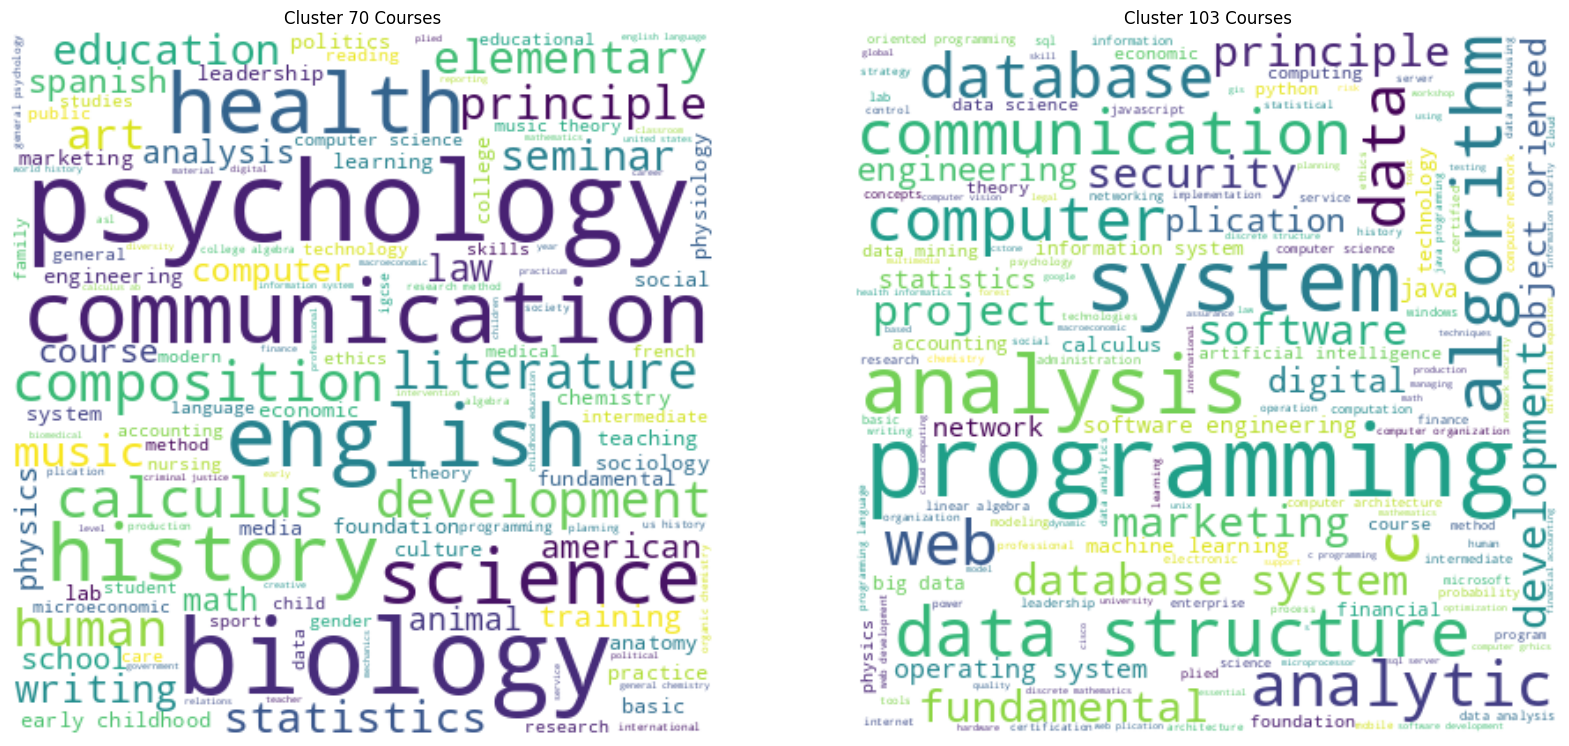

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, explode

claster_id_1 = 70
claster_id_2 = 103

# Filter profiles by cluster_id
cluster_profiles_1 = clustered_profiles.filter(col('cluster') == claster_id_1)
cluster_profiles_2 = clustered_profiles.filter(col('cluster') == claster_id_2)

# Collect 'courses.title' sections
courses_titles_1 = cluster_profiles_1.select(explode('сourses').alias('course')).select('course.title').rdd.flatMap(lambda x: x).collect()
courses_titles_2 = cluster_profiles_2.select(explode('сourses').alias('course')).select('course.title').rdd.flatMap(lambda x: x).collect()

# Combine all 'courses.title' sections into a single string
combined_text_1 = " ".join(courses_titles_1).lower()
combined_text_2 = " ".join(courses_titles_2).lower()

# Remove unwanted words
unwanted_words = ['ap', 'introduction', 'ii', 'advanced', 'intro', 'honors','business', 'design', 'design','management']
for word in unwanted_words:
    combined_text_1 = combined_text_1.replace(word, '')
    combined_text_2 = combined_text_2.replace(word, '')

# Generate word clouds
wordcloud_1 = WordCloud(width=400, height=400, background_color='white').generate(combined_text_1)
wordcloud_2 = WordCloud(width=400, height=400, background_color='white').generate(combined_text_2)

# Display the word clouds
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.title(f'Cluster {claster_id_1} Courses')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.title(f'Cluster {claster_id_2} Courses')

plt.show()

In [0]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType

profiles = spark.read.parquet('/dbfs/linkedin_people_train_data')
N = float(profiles.count())
print(f'N = {N}')
missing_columns = []
for column in profiles.columns:
    prec = (((profiles.filter(
        (col(column).isNull()) |
        (col(column).cast(StringType()) == "") |
        (col(column).cast(StringType()) == "NULL") |
        (col(column).cast(StringType()) == "[]") |
        (col(column).cast(StringType()) == "None")|
        (col(column).cast(StringType()) == "{}")
        )
    ).count())/N) * 100.0
    print('----------------------------------------------------------------------------------')
    print(f'column {column} has {prec:.2f}% missing values and  {100 - prec:.2f}% values')
    if 95.0 > prec > 2.0:
        missing_columns.append(column)
print('----------------------------------------------------------------------------------')
print(f'missing_columns: {missing_columns}')

N = 2768313.0
----------------------------------------------------------------------------------
column about has 78.96% missing values and  21.04% values
----------------------------------------------------------------------------------
column avatar has 0.00% missing values and  100.00% values
----------------------------------------------------------------------------------
column certifications has 90.42% missing values and  9.58% values
----------------------------------------------------------------------------------
column city has 0.00% missing values and  100.00% values
----------------------------------------------------------------------------------
column country_code has 0.00% missing values and  100.00% values
----------------------------------------------------------------------------------
column current_company has 0.00% missing values and  100.00% values
----------------------------------------------------------------------------------
column current_company:company_i

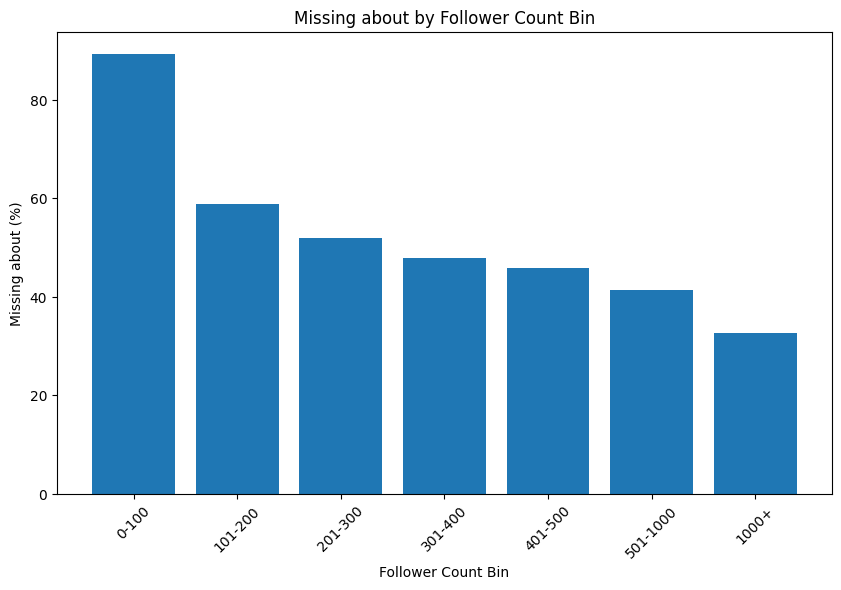

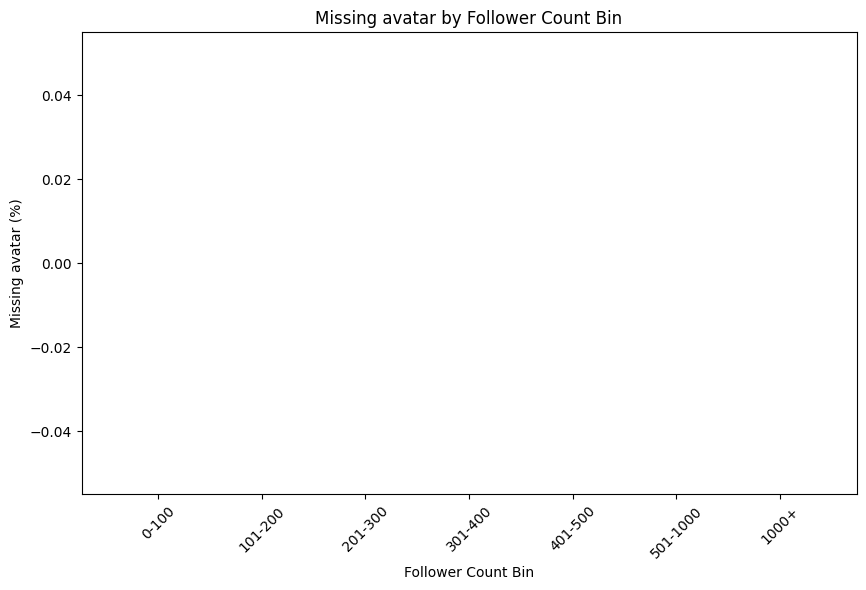

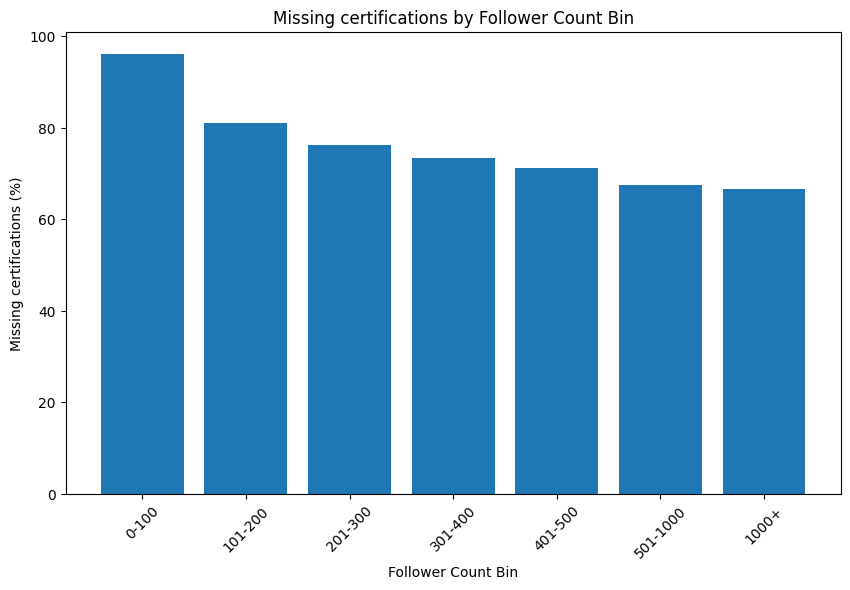

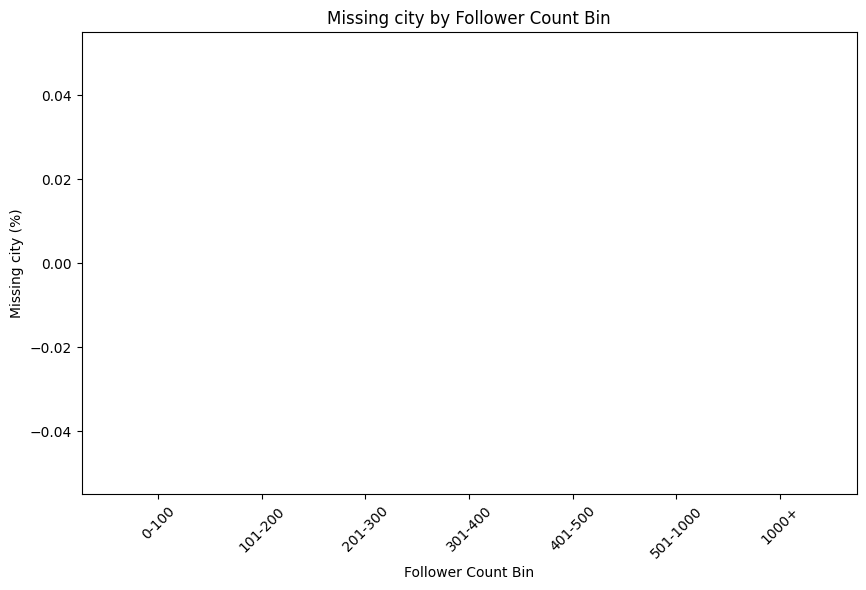

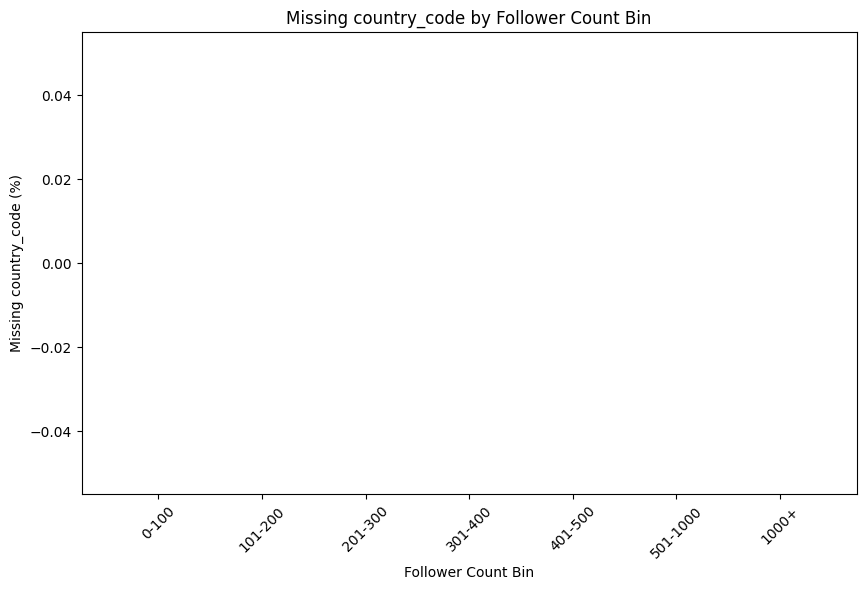

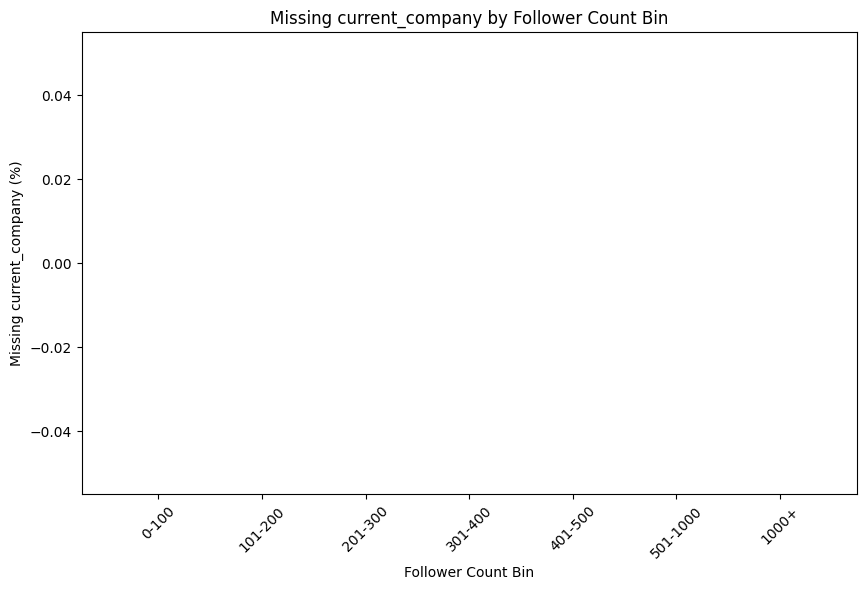

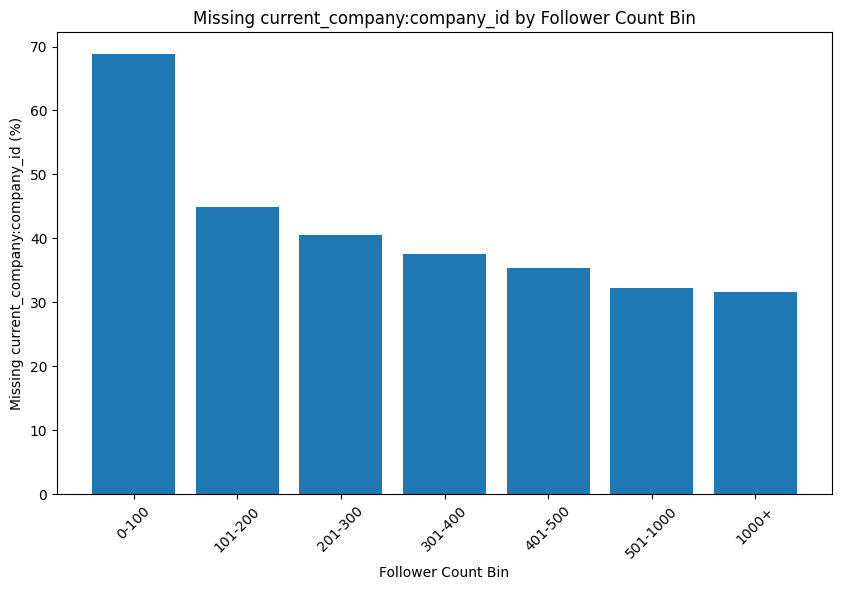

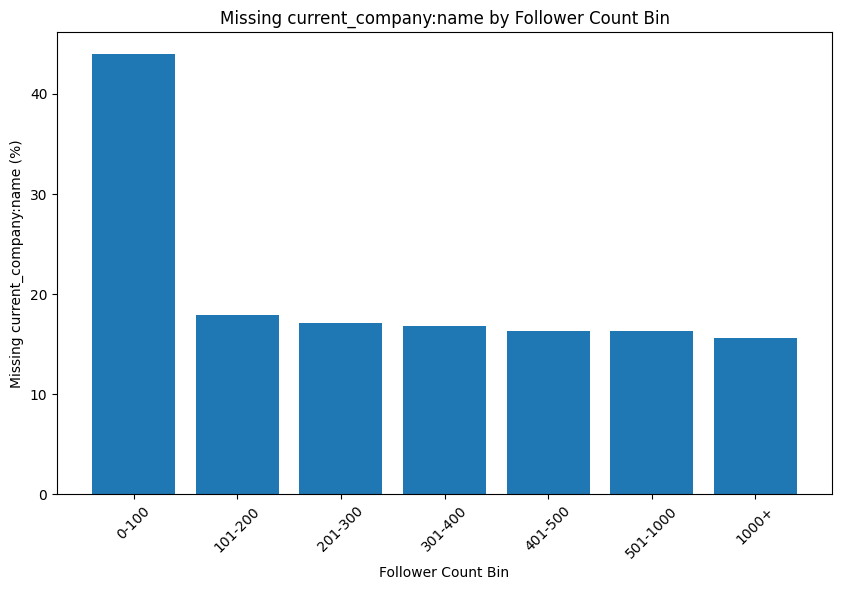

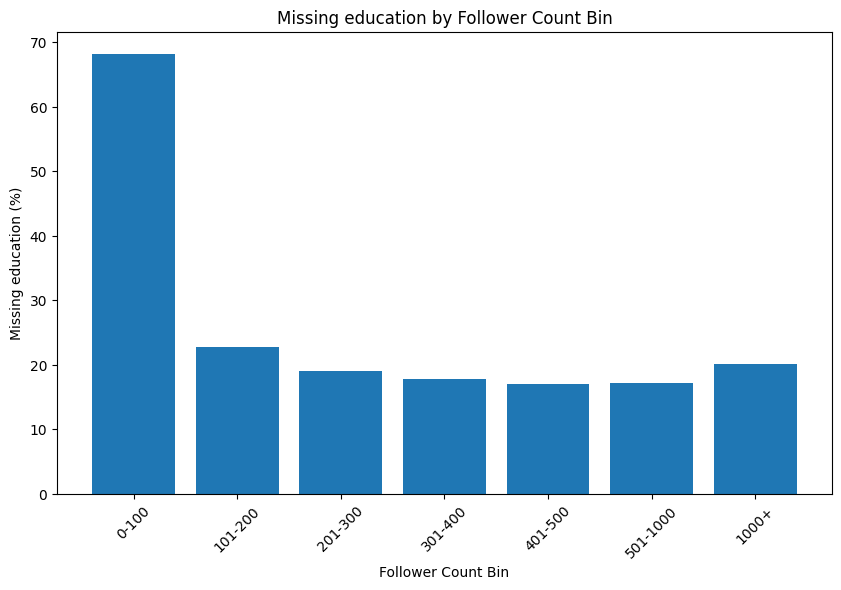

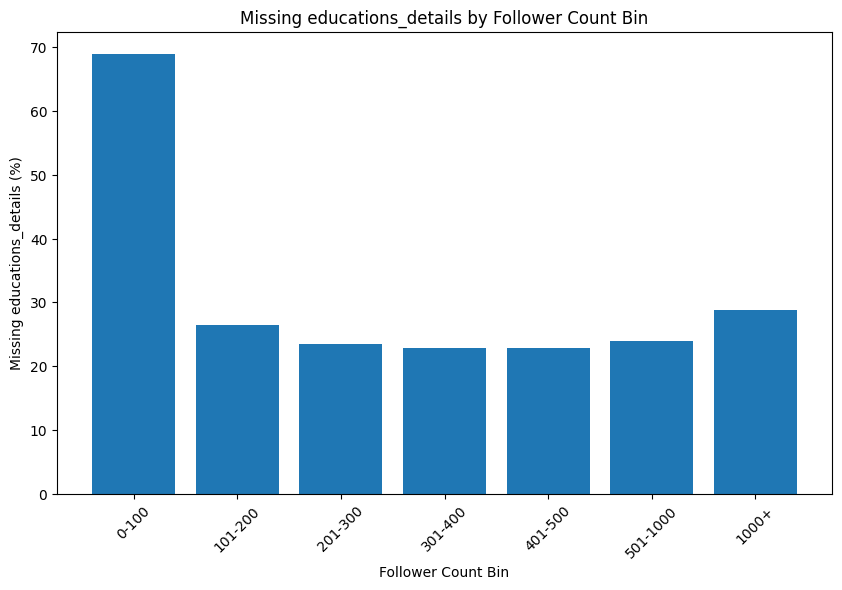

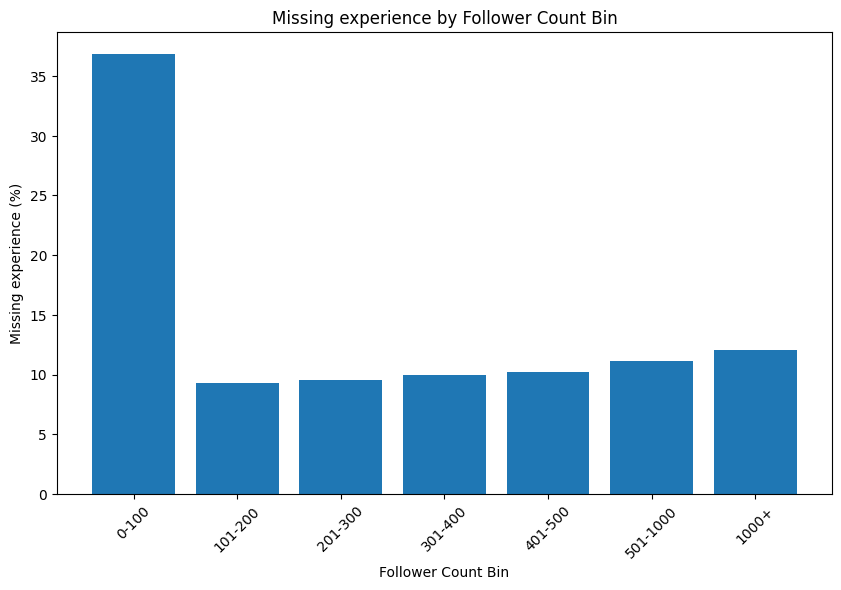

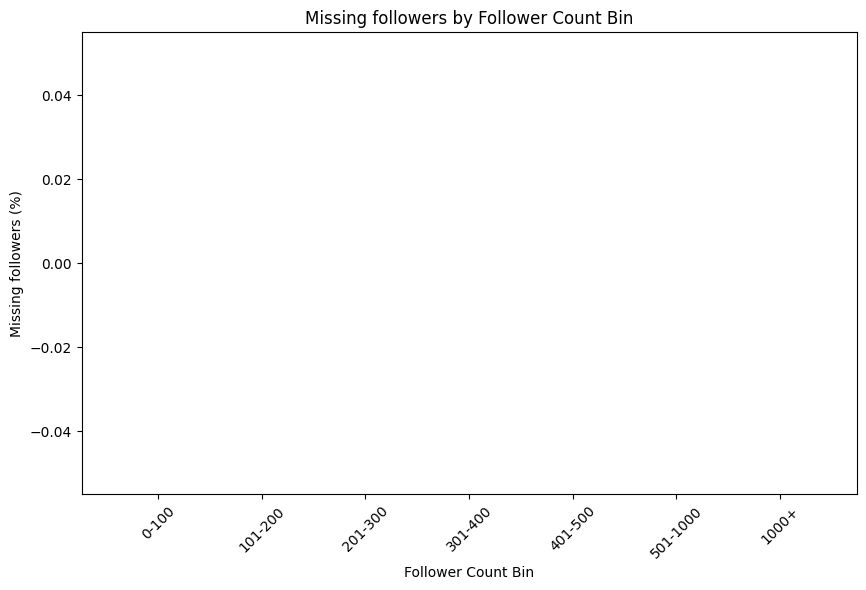

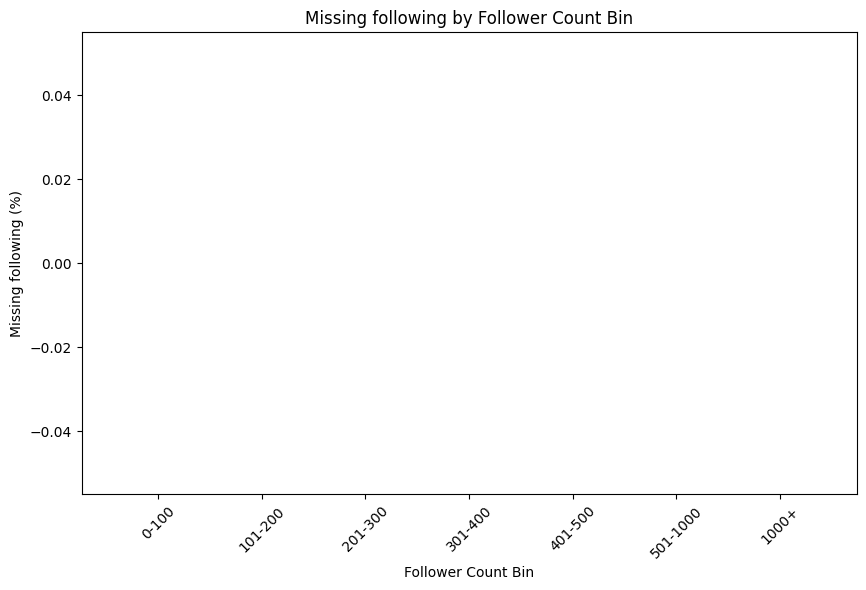

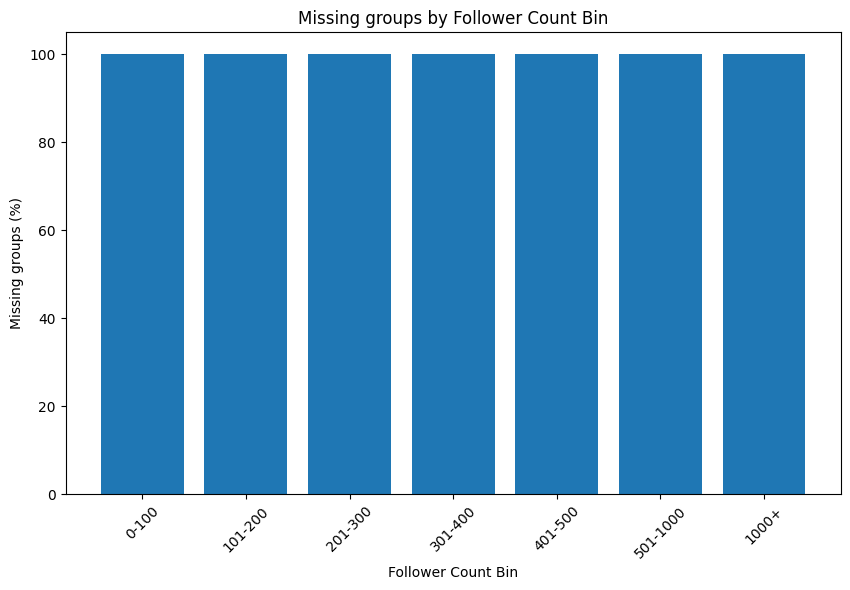

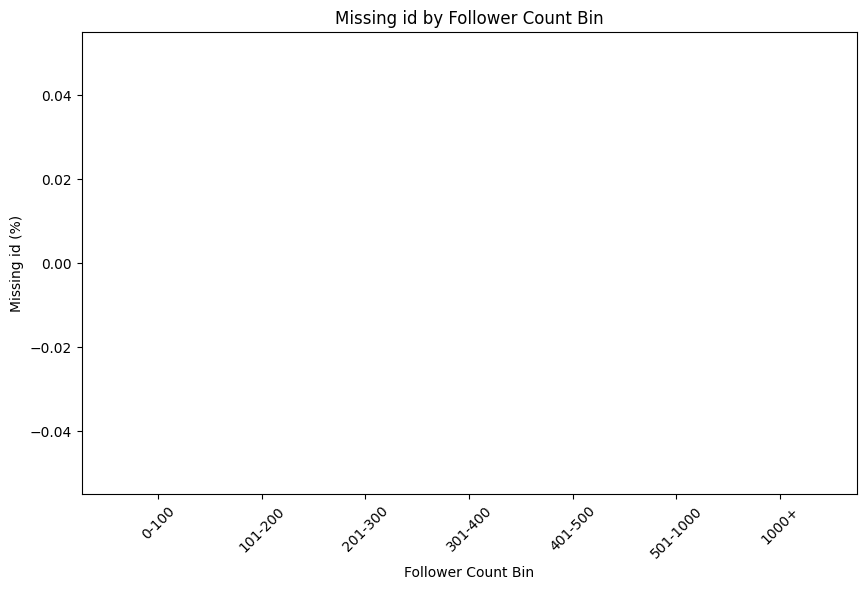

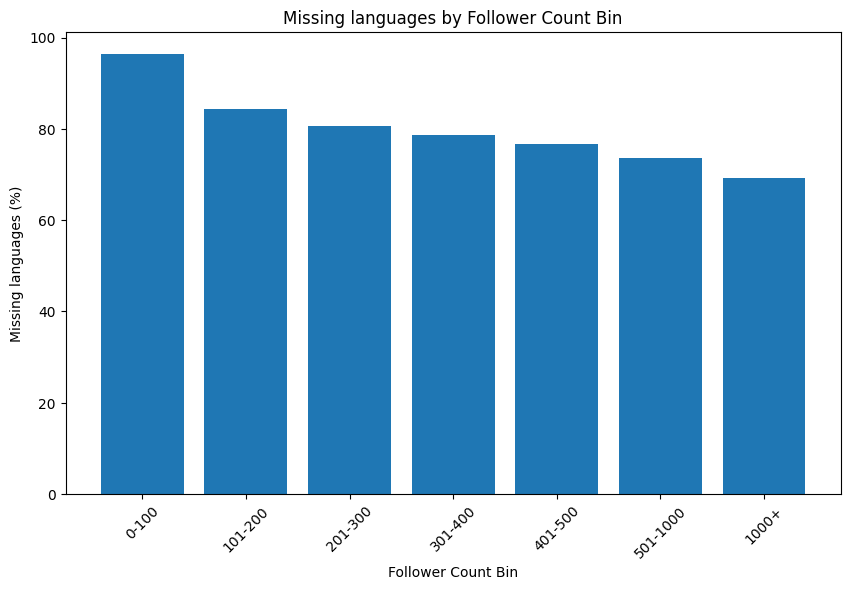

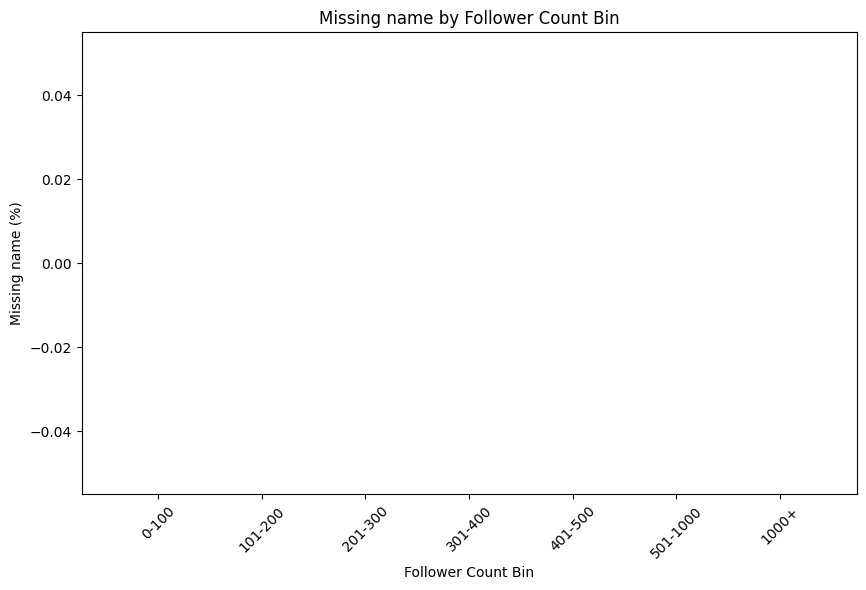

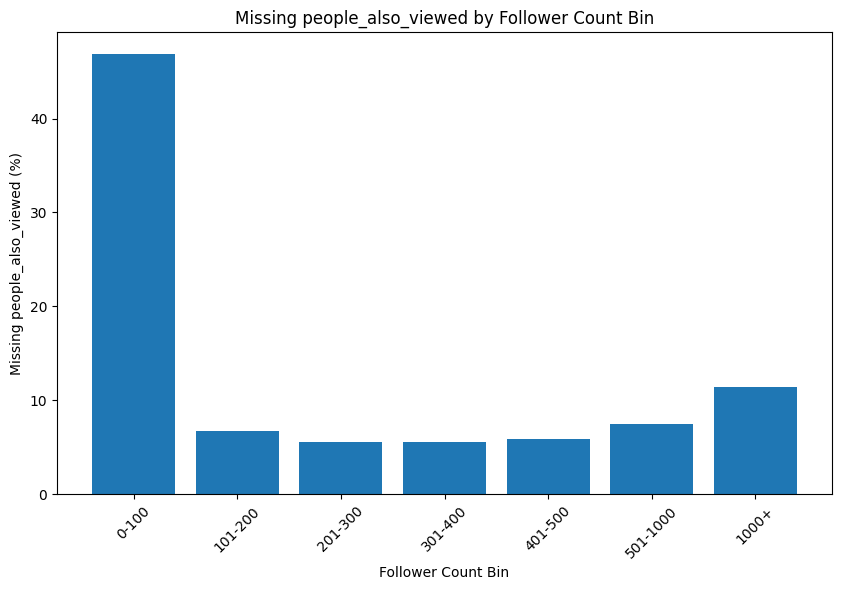

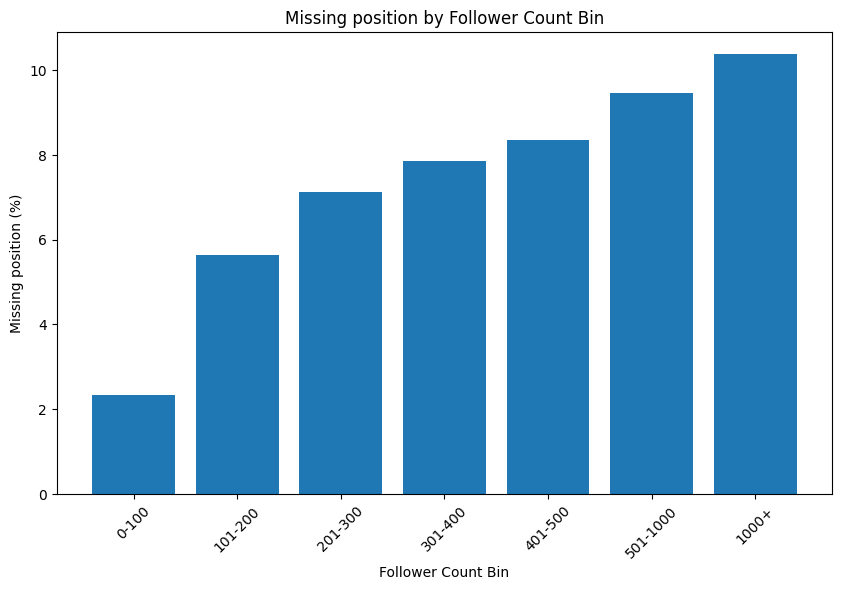

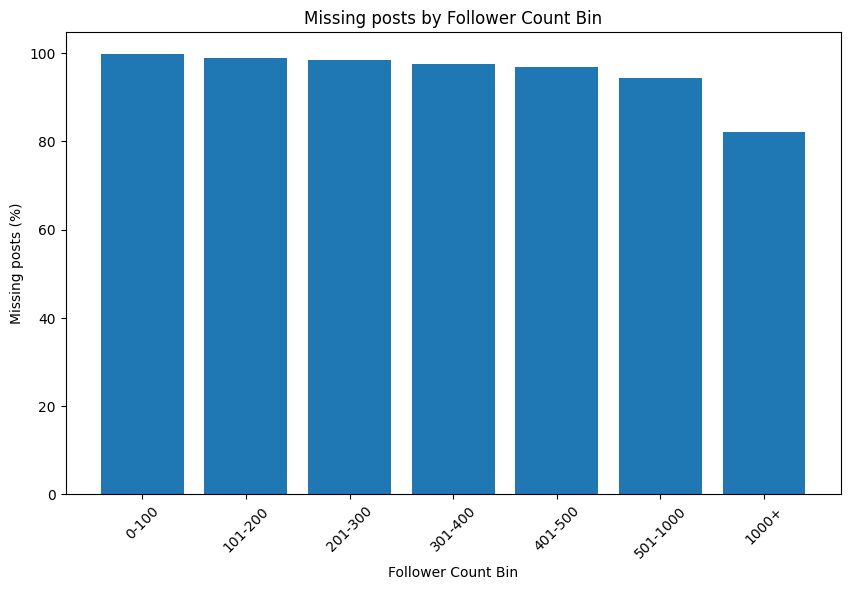

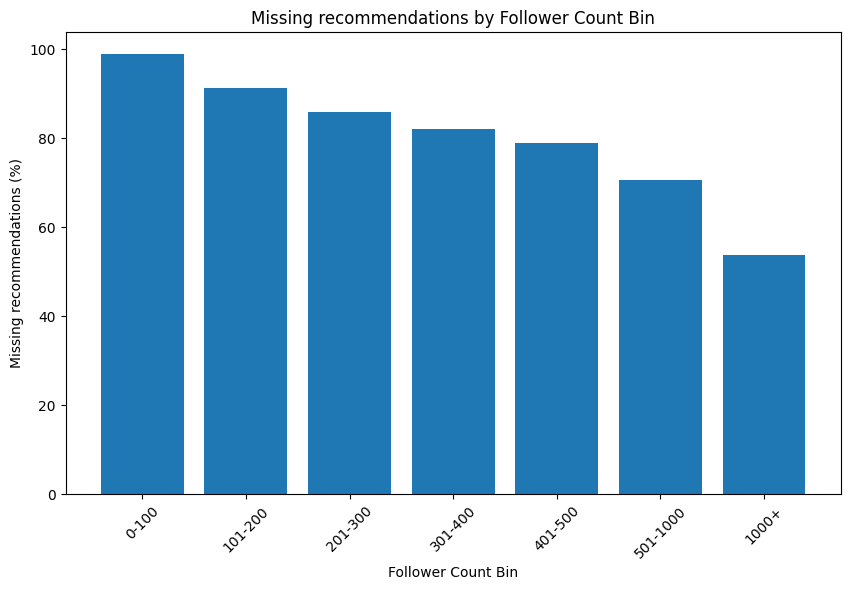

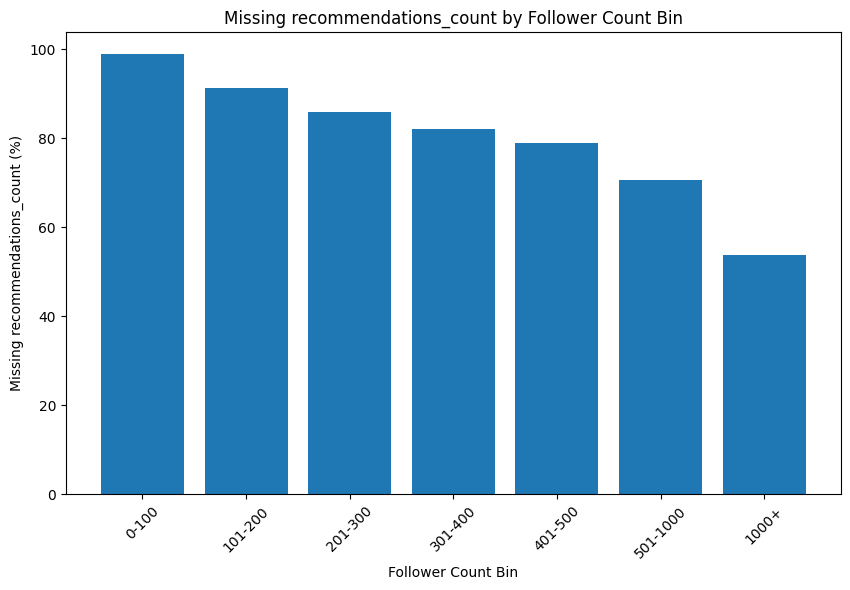

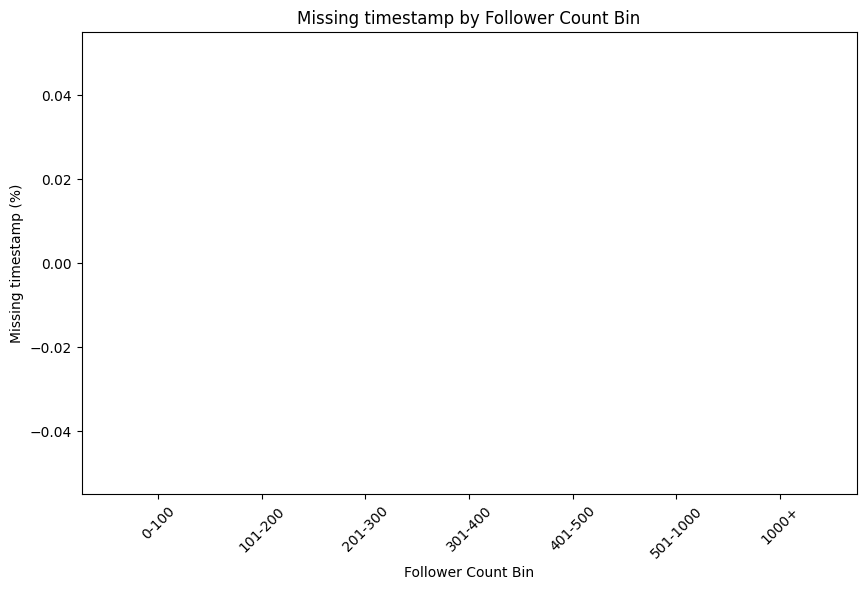

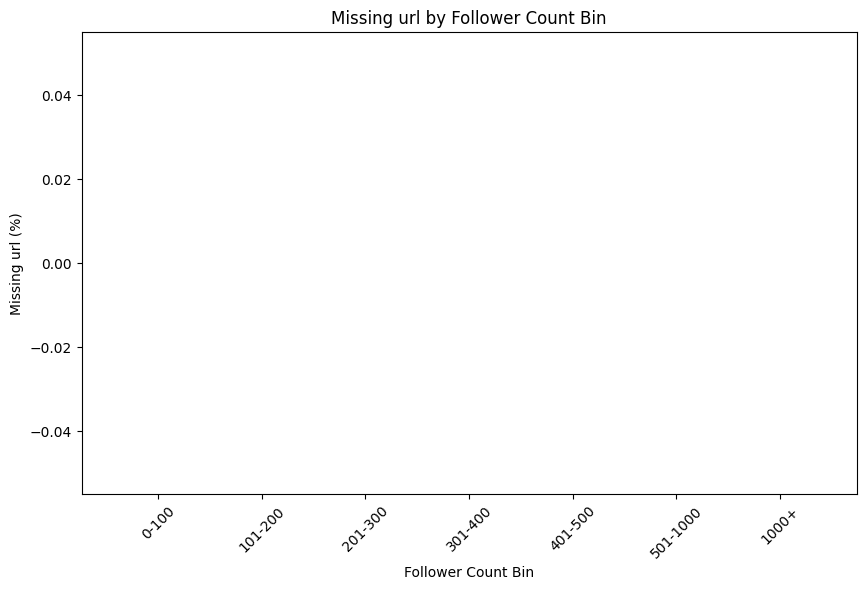

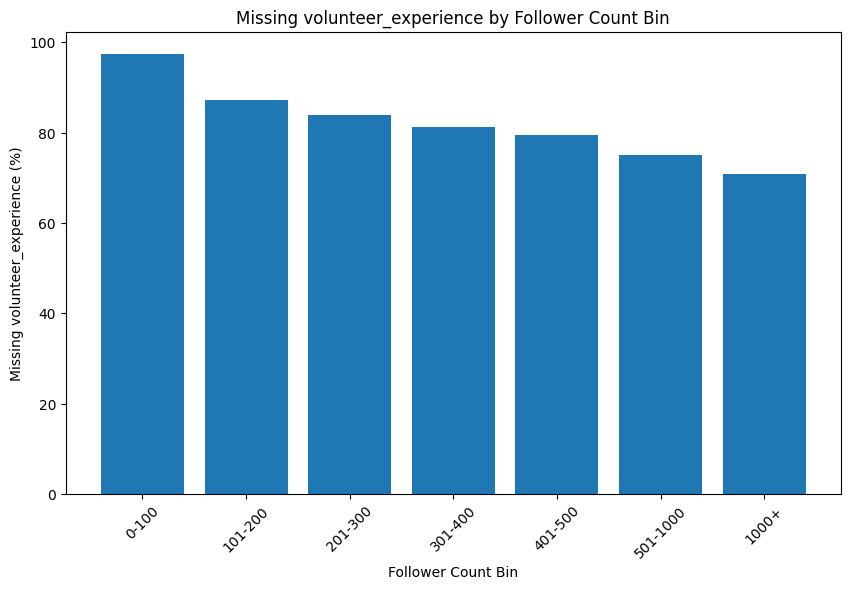

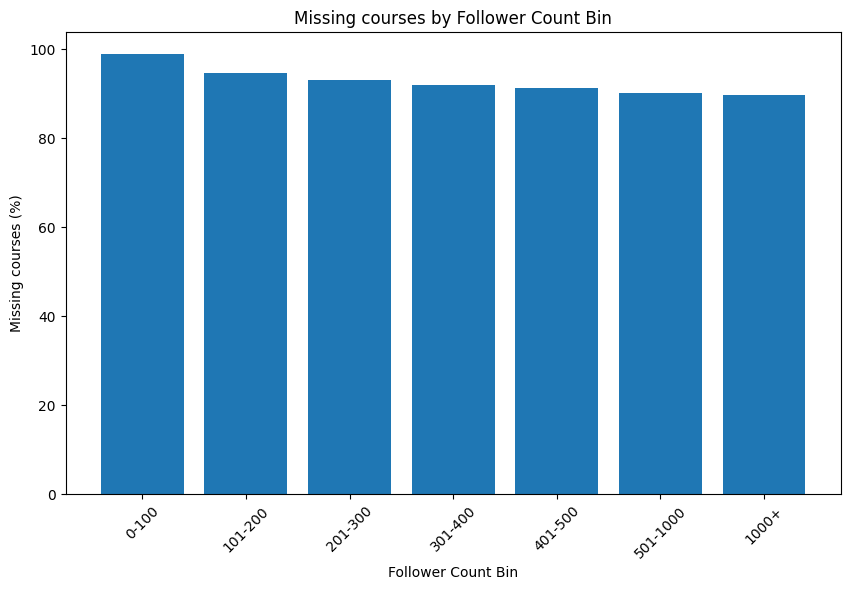

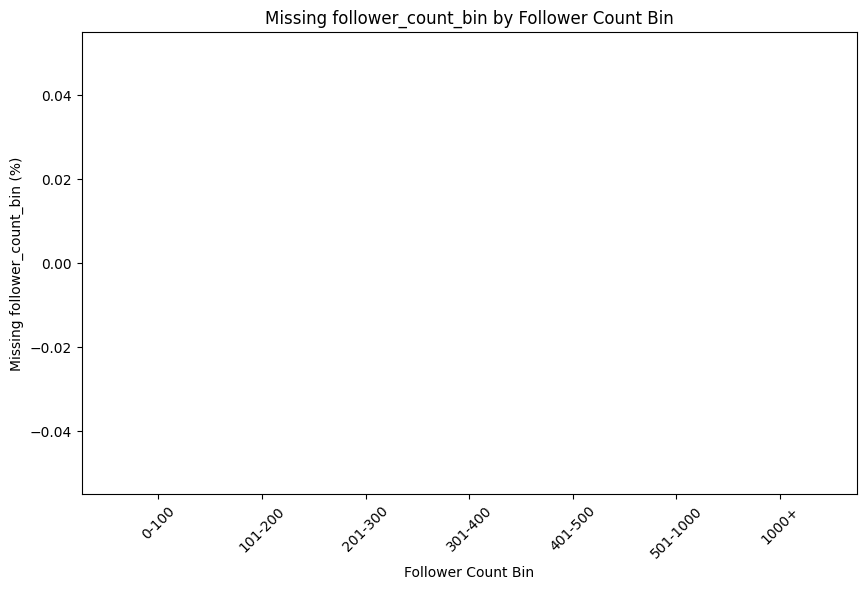

In [0]:
from pyspark.sql.functions import col, when, count, lit, round
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType

# Read profiles data
profiles = spark.read.parquet('/dbfs/linkedin_people_train_data')

# Define missing value conditions
def missing_conditions(column):
    return (
        (col(column).isNull()) |
        (col(column).cast(StringType()) == "") |
        (col(column).cast(StringType()) == "NULL") |
        (col(column).cast(StringType()) == "[]") |
        (col(column).cast(StringType()) == "None") |
        (col(column).cast(StringType()) == "{}")
    )

# Create bins for follower count
profiles = profiles.withColumn(
    'follower_count_bin',
    when(col('followers') <= 100, '0-100')
    .when((col('followers') > 100) & (col('followers') <= 200), '101-200')
    .when((col('followers') > 200) & (col('followers') <= 300), '201-300')
    .when((col('followers') > 300) & (col('followers') <= 400), '301-400')
    .when((col('followers') > 400) & (col('followers') <= 500), '401-500')
    .when((col('followers') > 500) & (col('followers') <= 1000), '501-1000')
    .otherwise('1000+')
)

# Calculate missingness percentage grouped by follower count bins
missingness_df = profiles.groupBy('follower_count_bin').agg(
    *[round((count(when(missing_conditions(column), column)) / count(lit(1))) * 100, 2).alias(f'missing_{column}') for column in profiles.columns]
)

# Convert to Pandas DataFrame for plotting
missingness_pd_df = missingness_df.toPandas()

# Plot missingness for each column
for column in profiles.columns:
    if f'missing_{column}' in missingness_pd_df.columns:
        missingness_pd_df = missingness_pd_df.sort_values(by='follower_count_bin', key=lambda x: x.str.extract('(\d+)', expand=False).astype(int))
        plt.figure(figsize=(10, 6))
        plt.bar(missingness_pd_df['follower_count_bin'], missingness_pd_df[f'missing_{column}'])
        plt.xlabel('Follower Count Bin')
        plt.ylabel(f'Missing {column} (%)')
        plt.title(f'Missing {column} by Follower Count Bin')
        plt.xticks(rotation=45)
        plt.show()

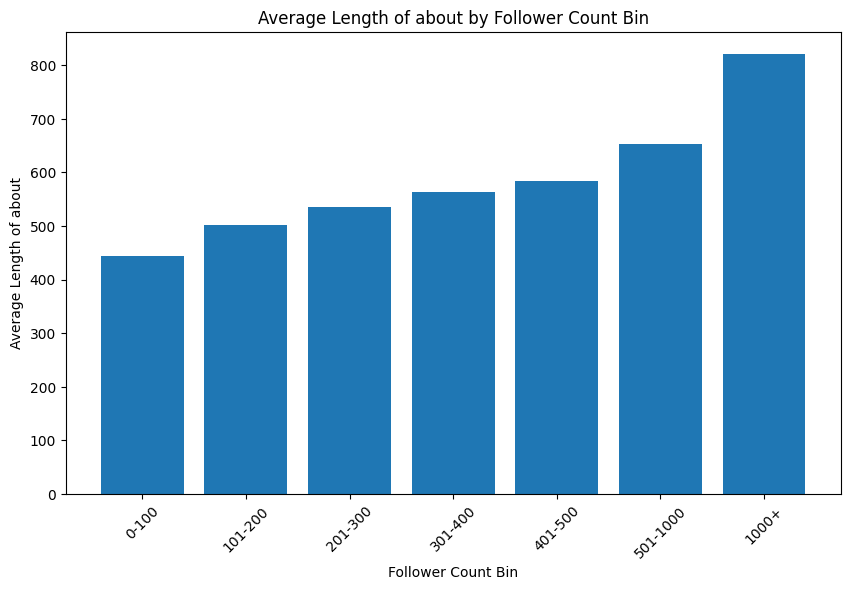

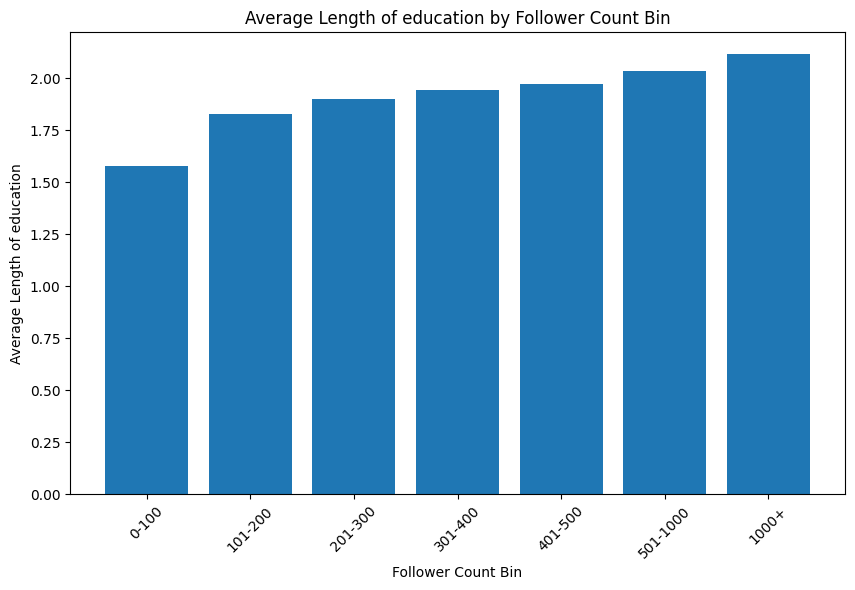

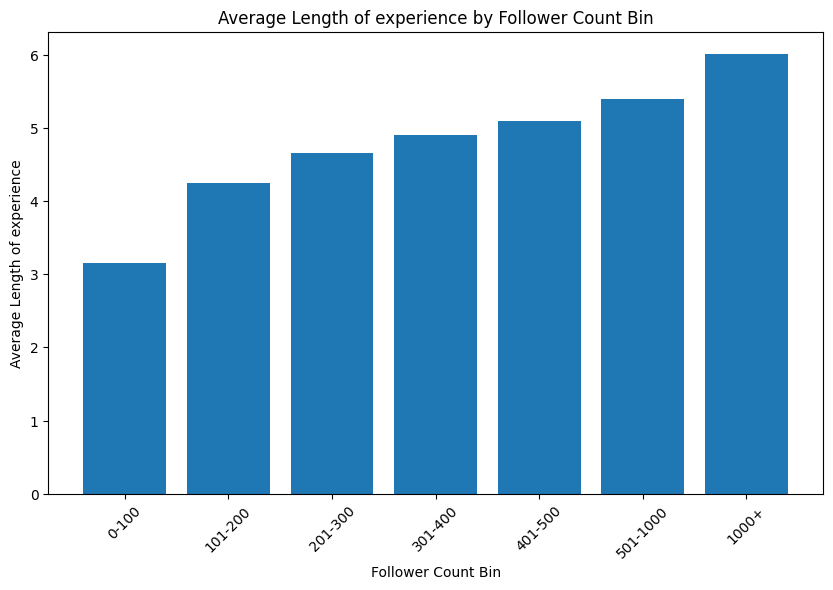

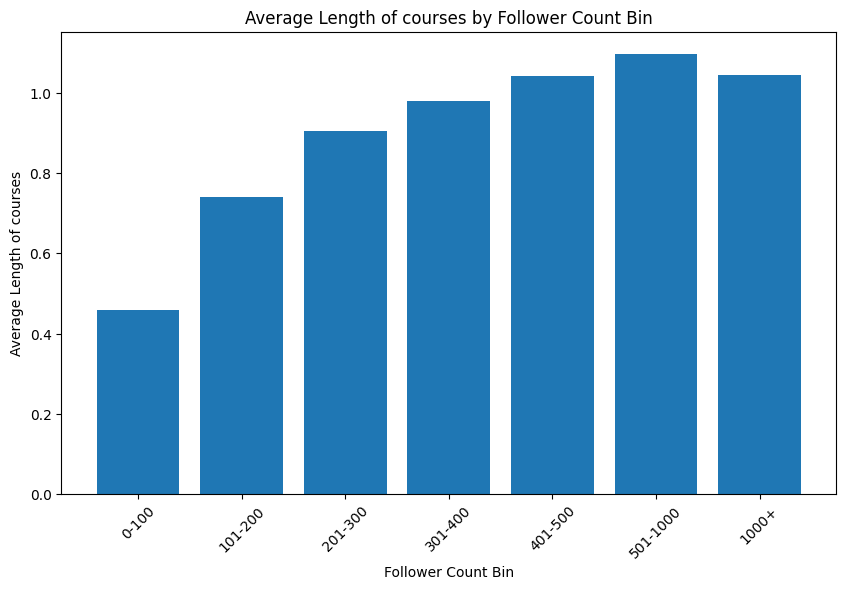

In [0]:
from pyspark.sql.functions import col, when, length, avg, size
import matplotlib.pyplot as plt

# Read profiles data
profiles = spark.read.parquet('/dbfs/linkedin_people_train_data')
profiles = profiles.filter(col('about').isNotNull())
# Columns to calculate length
length_columns = ['about']
array_columns = ['education', 'experience',  'сourses']

# Create bins for follower count
profiles = profiles.withColumn(
    'follower_count_bin',
    when(col('followers') <= 100, '0-100')
    .when((col('followers') > 100) & (col('followers') <= 200), '101-200')
    .when((col('followers') > 200) & (col('followers') <= 300), '201-300')
    .when((col('followers') > 300) & (col('followers') <= 400), '301-400')
    .when((col('followers') > 400) & (col('followers') <= 500), '401-500')
    .when((col('followers') > 500) & (col('followers') <= 1000), '501-1000')
    .otherwise('1000+')
)

# Calculate average length grouped by follower count bins
length_df = profiles.groupBy('follower_count_bin').agg(
    *[avg(length((col(column)).cast(StringType()))).alias(f'avg_length_{column}') for column in length_columns if column != 'recommendations'] + [avg(size(col('recommendations'))).alias('avg_length_recommendations')] ,
    *[avg(size(col(column))).alias(f'avg_length_{column}') for column in array_columns]
)

# Convert to Pandas DataFrame for plotting
length_pd_df = length_df.toPandas()

# Plot average length for each column
for column in length_columns + array_columns:
    if f'avg_length_{column}' in length_pd_df.columns:
        plt.figure(figsize=(10, 6))
        sorted_df = length_pd_df.sort_values(by='follower_count_bin', key=lambda x: x.str.extract('(\d+)', expand=False).astype(int))
        plt.bar(sorted_df['follower_count_bin'], sorted_df[f'avg_length_{column}'])
        plt.xlabel('Follower Count Bin')
        plt.ylabel(f'Average Length of {column}')
        plt.title(f'Average Length of {column} by Follower Count Bin')
        plt.xticks(rotation=45)
        plt.show()